# DM-37622: test diffimg sprint dataset with HSM shape

### N.B. This notebook requires you to have analysis_ap set up in your environment, and it must contain the plotImageSubtractionCutouts code (formerly zooniverseCutouts, which will not work).

In [1]:
import sys
import glob
import gc
from lsst.daf.butler import Butler
import lsst.daf.butler as dafButler
import lsst.geom
import lsst.afw.display as afwDisplay
import lsst.afw.display as afw_display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.ndimage
#afwDisplay.setDefaultBackend('matplotlib') 
from lsst.pipe.tasks.scaleZeroPoint import ScaleZeroPointTask
task = ScaleZeroPointTask()

from types import SimpleNamespace
from astropy.visualization import (ZScaleInterval, SqrtStretch, ImageNormalize)
from astropy.coordinates import Angle, Latitude, Longitude, SkyCoord
from astropy import units as u

from lsst.ap.association import UnpackApdbFlags, TransformDiaSourceCatalogConfig
from lsst.pipe.base import Struct

import IPython
from IPython.display import IFrame, Image
from lsst.analysis.ap import apdb

In [2]:
repo = '/sdf/group/rubin/repo/main'
butler = dafButler.Butler(repo)

In [3]:
hsm_convolveTemplate =  SimpleNamespace(collection = 'u/kherner/DM-37122/HSMshape_bestThirdSeeing_convolveTemplate',
                                       apdb = 'lsst-devl',
                                       schema='kherner_dm37122_convolvetemplate',
                                      templName='goodSeeing')
best_convolveTemplate = SimpleNamespace(collection = 'u/kherner/DM-35283/w46_bestThirdSeeing_convolveTemplate',
                                       apdb = 'lsst-devl',
                                       schema='kherner_dm35283_w46_convolvetemplate',
                                      templName='goodSeeing')
default_convolveTemplate =  SimpleNamespace(collection = 'u/kherner/DM-37622/HSMshape_bestThirdSeeing_convolveTemplate',
                                       apdb = 'lsst-devl',
                                       schema='kherner_dm37622_convolvetemplate',
                                      templName='goodSeeing')
w04_convolveTemplate = SimpleNamespace(collection = 'u/kherner/DM-37622/w_2023_04_bestThirdSeeing_convolveTemplate',
                                       apdb = 'lsst-devl',
                                       schema='kherner_dm37622_w_2023_04_convolvetemplate',
                                      templName='goodSeeing')

In [4]:
badFlagList = ['base_PixelFlags_flag_bad',
               'base_PixelFlags_flag_suspect',
               'base_PixelFlags_flag_saturatedCenter',
               'base_PixelFlags_flag_interpolated',
               'base_PixelFlags_flag_interpolatedCenter',
               'base_PixelFlags_flag_edge',
              ]

In [5]:
apdbs_nonempty = [ hsm_convolveTemplate, best_convolveTemplate,
                  default_convolveTemplate, w04_convolveTemplate]

In [6]:
oneVisit = 1220
oneDetector = 66
selname = 'fakes_goodSeeing'

diffim variance median
----------------------
711.497803	HSMshape_bestThirdSeeing_convolveTemplate
711.499634	w46_bestThirdSeeing_convolveTemplate
711.497803	HSMshape_bestThirdSeeing_convolveTemplate
711.497803	w_2023_04_bestThirdSeeing_convolveTemplate


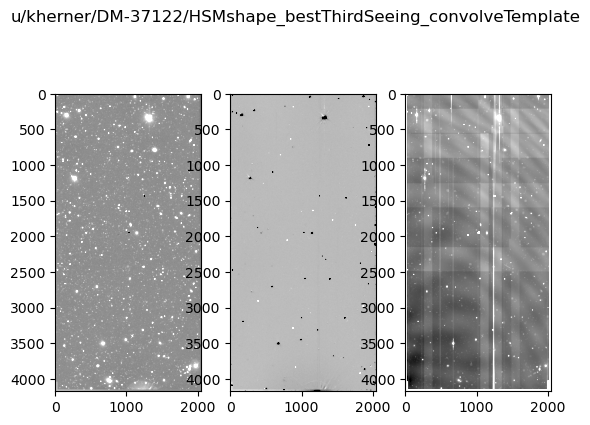

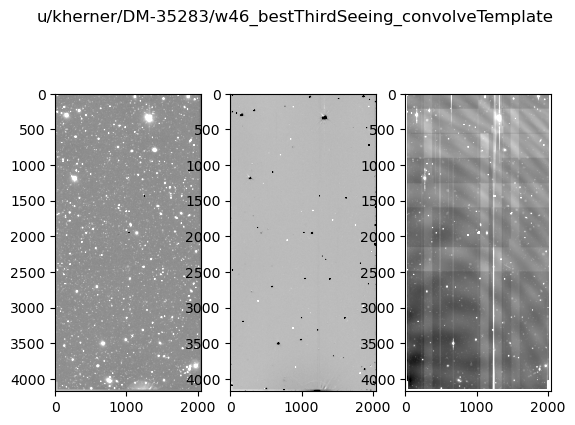

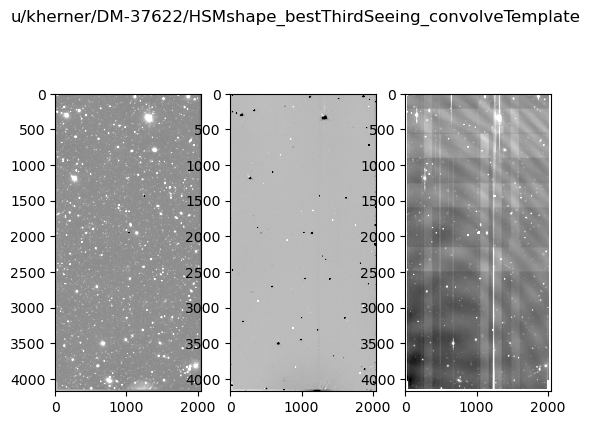

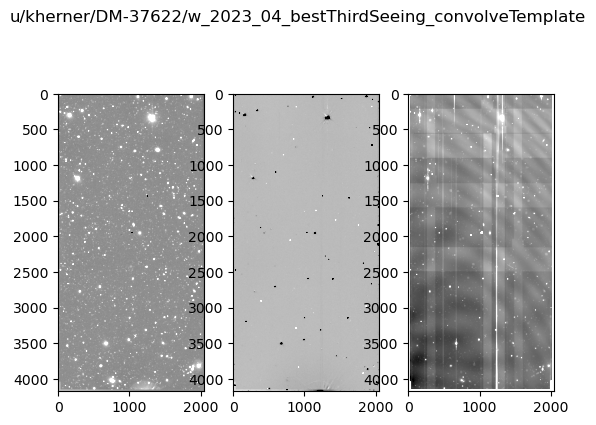

In [7]:
collection_list = [ i.collection for i in apdbs_nonempty ]
print(f'diffim variance median')
print(f'----------------------')
for collections in collection_list:
#for collections in [default_best.collection, preconvolve_best.collection]:
    calexp = butler.get('calexp', instrument='HSC',
                        visit=oneVisit, detector=oneDetector, collections=collections)
    diffim = butler.get(selname+'Diff_differenceExp', instrument='HSC',
                        visit=oneVisit, detector=oneDetector, collections=collections)

    calexpNorm = ImageNormalize(calexp.image.array, interval=ZScaleInterval(), stretch=SqrtStretch())
    diffimNorm = ImageNormalize(diffim.image.array, interval=ZScaleInterval(), stretch=SqrtStretch())
    diffimVarNorm = ImageNormalize(diffim.variance.array, interval=ZScaleInterval(), stretch=SqrtStretch())

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    fig.suptitle(collections)
    ax1.imshow(calexp.image.array, cmap='gray', norm=calexpNorm)
    ax2.imshow(diffim.image.array, cmap='gray', norm=diffimNorm)
    ax3.imshow(diffim.variance.array, cmap='gray', norm=diffimVarNorm)
    
    print(f'{np.median(diffim.variance.array):8f}\t{collections.split("/")[-1]}')

In [8]:
class PathManager:
    """Manage paths to local files, chunked directories, and s3 buckets.
    Parameters
    ----------
    root : `str`
        Root file path to manage.
    chunk_size : `int`, optional
        How many files per directory?
    """
    def __init__(self, root, chunk_size=None):
        self._root = root
        if chunk_size is not None and chunk_size % 10 != 0:
            raise RuntimeError(f"PathManager file chunking must be a multiple of 10, got {chunk_size}.")
        self._chunk_size = chunk_size
        
    def __call__(self, id=None, filename=None):
        """Return the full path to this diaSourceId cutout.
        Parameters
        ----------
        id : `int`
            Description
        filename : None, optional
            Description
        Returns
        -------
        TYPE
            Description
        """
        def chunker(id, size):
            return (id // size)*size
        
        if id is not None:
            if self._chunk_size is not None:
                return os.path.join(self._root, f"images/{chunker(id, self._chunk_size)}/{id}.png")
            else:
                return os.path.join(self._root, f"images/{id}.png")
        elif filename is not None:
            return os.path.join(self._root, filename)

In [9]:
hsmQuery = apdb.ApdbPostgresQuery(hsm_convolveTemplate.schema, butler=butler, instrument="HSC")
hsmsources = hsmQuery.load_sources()
hsmobjects = hsmQuery.load_objects()
goodHsm = hsmQuery.load_sources(exclude_flagged=True)

/sdf/group/rubin/u/kherner/DM-37622/analysis_ap/python/lsst/analysis/ap/apdb.py:315: FutureWarning: Call to deprecated method makePacker. (Deprecated in favor of configurable dimension packers.  Will be removed after v27.) -- Deprecated since version v26.
  packer = self._butler.registry.dimensions.makePacker("visit_detector", instrumentDataId)
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-6.0.0/Linux64/daf_butler/g98bc2251b0+353af21826/python/lsst/daf/butler/core/dimensions/_packer.py:241: FutureWarning: Call to deprecated class ObservationDimensionPacker. (Deprecated in favor of configurable dimension packers.  Will be removed after v27.) -- Deprecated since version v26.
  return self._cls(fixed, self._dimensions)
/sdf/group/rubin/u/kherner/DM-37622/analysis_ap/python/lsst/analysis/ap/apdb.py:315: FutureWarning: Call to deprecated method makePacker. (Deprecated in favor of configurable dimension packers.  Will be removed after v27.) -- Deprecated since version v26.
  packer = 

In [10]:
bestQuery = apdb.ApdbPostgresQuery(best_convolveTemplate.schema, butler=butler, instrument="HSC")
bestsources = bestQuery.load_sources()
bestobjects = bestQuery.load_objects()
goodBest = bestQuery.load_sources(exclude_flagged=True)

/sdf/group/rubin/u/kherner/DM-37622/analysis_ap/python/lsst/analysis/ap/apdb.py:315: FutureWarning: Call to deprecated method makePacker. (Deprecated in favor of configurable dimension packers.  Will be removed after v27.) -- Deprecated since version v26.
  packer = self._butler.registry.dimensions.makePacker("visit_detector", instrumentDataId)
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-6.0.0/Linux64/daf_butler/g98bc2251b0+353af21826/python/lsst/daf/butler/core/dimensions/_packer.py:241: FutureWarning: Call to deprecated class ObservationDimensionPacker. (Deprecated in favor of configurable dimension packers.  Will be removed after v27.) -- Deprecated since version v26.
  return self._cls(fixed, self._dimensions)
/sdf/group/rubin/u/kherner/DM-37622/analysis_ap/python/lsst/analysis/ap/apdb.py:315: FutureWarning: Call to deprecated method makePacker. (Deprecated in favor of configurable dimension packers.  Will be removed after v27.) -- Deprecated since version v26.
  packer = 

In [11]:
defaultQuery = apdb.ApdbPostgresQuery(default_convolveTemplate.schema, butler=butler, instrument="HSC")
defaultsources = defaultQuery.load_sources()
defaultobjects = defaultQuery.load_objects()
goodDefault = defaultQuery.load_sources(exclude_flagged=True)

/sdf/group/rubin/u/kherner/DM-37622/analysis_ap/python/lsst/analysis/ap/apdb.py:315: FutureWarning: Call to deprecated method makePacker. (Deprecated in favor of configurable dimension packers.  Will be removed after v27.) -- Deprecated since version v26.
  packer = self._butler.registry.dimensions.makePacker("visit_detector", instrumentDataId)
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-6.0.0/Linux64/daf_butler/g98bc2251b0+353af21826/python/lsst/daf/butler/core/dimensions/_packer.py:241: FutureWarning: Call to deprecated class ObservationDimensionPacker. (Deprecated in favor of configurable dimension packers.  Will be removed after v27.) -- Deprecated since version v26.
  return self._cls(fixed, self._dimensions)
/sdf/group/rubin/u/kherner/DM-37622/analysis_ap/python/lsst/analysis/ap/apdb.py:315: FutureWarning: Call to deprecated method makePacker. (Deprecated in favor of configurable dimension packers.  Will be removed after v27.) -- Deprecated since version v26.
  packer = 

In [12]:
w04Query = apdb.ApdbPostgresQuery(w04_convolveTemplate.schema, butler=butler, instrument="HSC")
w04sources = w04Query.load_sources()
w04objects = w04Query.load_objects()
goodw04 = w04Query.load_sources(exclude_flagged=True)

/sdf/group/rubin/u/kherner/DM-37622/analysis_ap/python/lsst/analysis/ap/apdb.py:315: FutureWarning: Call to deprecated method makePacker. (Deprecated in favor of configurable dimension packers.  Will be removed after v27.) -- Deprecated since version v26.
  packer = self._butler.registry.dimensions.makePacker("visit_detector", instrumentDataId)
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-6.0.0/Linux64/daf_butler/g98bc2251b0+353af21826/python/lsst/daf/butler/core/dimensions/_packer.py:241: FutureWarning: Call to deprecated class ObservationDimensionPacker. (Deprecated in favor of configurable dimension packers.  Will be removed after v27.) -- Deprecated since version v26.
  return self._cls(fixed, self._dimensions)
/sdf/group/rubin/u/kherner/DM-37622/analysis_ap/python/lsst/analysis/ap/apdb.py:315: FutureWarning: Call to deprecated method makePacker. (Deprecated in favor of configurable dimension packers.  Will be removed after v27.) -- Deprecated since version v26.
  packer = 

In [13]:
print(f'{len(hsmsources):7d}\t{len(goodHsm):7d}\t\t{hsm_convolveTemplate.collection.split("/")[-1]}')

print(f'{len(bestsources):7d}\t{len(goodBest):7d}\t\t{best_convolveTemplate.collection.split("/")[-1]}')

print(f'{len(defaultsources):7d}\t{len(goodDefault):7d}\t\t{default_convolveTemplate.collection.split("/")[-1]}')

print(f'{len(w04sources):7d}\t{len(goodw04):7d}\t\t{w04_convolveTemplate.collection.split("/")[-1]}')

  54761	  13243		HSMshape_bestThirdSeeing_convolveTemplate
  54762	  13255		w46_bestThirdSeeing_convolveTemplate
  54765	  13258		HSMshape_bestThirdSeeing_convolveTemplate
  54765	  13258		w_2023_04_bestThirdSeeing_convolveTemplate


In [14]:
import gc
gc.collect()

0

### Make some cutouts

In [15]:
from lsst.analysis.ap import plotImageSubtractionCutouts

In [16]:
config = plotImageSubtractionCutouts.PlotImageSubtractionCutoutsConfig()
config.url_root = ''
config.add_metadata = False
config.diff_image_type = 'goodSeeingDiff'
outbase = '/sdf/data/rubin/user/kherner/DM-37622/'
zcDefault = plotImageSubtractionCutouts.PlotImageSubtractionCutoutsTask(output_path=outbase+"/cutouts_DM-37622_SlotShapeDefault",
                                                    config=config)
zc04 = plotImageSubtractionCutouts.PlotImageSubtractionCutoutsTask(output_path=outbase+"/cutouts_DM-37622_w04",
                                               config=config)

In [17]:
slotShapeQuery = apdb.ApdbPostgresQuery(default_convolveTemplate.schema, butler=butler, instrument="HSC")
slotShapeQuery.set_excluded_diaSource_flags(badFlagList)

In [18]:
slotShapew04Query = apdb.ApdbPostgresQuery(w04_convolveTemplate.schema, butler=butler, instrument="HSC")
slotShapew04Query.set_excluded_diaSource_flags(badFlagList)

In [19]:
goodSlotShape = slotShapeQuery.load_sources(exclude_flagged=True, limit=1000000)
goodSlotShapew04 = slotShapew04Query.load_sources(exclude_flagged=True, limit=1000000)

/sdf/group/rubin/u/kherner/DM-37622/analysis_ap/python/lsst/analysis/ap/apdb.py:315: FutureWarning: Call to deprecated method makePacker. (Deprecated in favor of configurable dimension packers.  Will be removed after v27.) -- Deprecated since version v26.
  packer = self._butler.registry.dimensions.makePacker("visit_detector", instrumentDataId)
/opt/lsst/software/stack/stack/miniconda3-py38_4.9.2-6.0.0/Linux64/daf_butler/g98bc2251b0+353af21826/python/lsst/daf/butler/core/dimensions/_packer.py:241: FutureWarning: Call to deprecated class ObservationDimensionPacker. (Deprecated in favor of configurable dimension packers.  Will be removed after v27.) -- Deprecated since version v26.
  return self._cls(fixed, self._dimensions)
/sdf/group/rubin/u/kherner/DM-37622/analysis_ap/python/lsst/analysis/ap/apdb.py:315: FutureWarning: Call to deprecated method makePacker. (Deprecated in favor of configurable dimension packers.  Will be removed after v27.) -- Deprecated since version v26.
  packer = 

In [20]:
visit_det = set(zip(goodSlotShape['visit'],goodSlotShape['detector']))

In [21]:
def doCrossmatch(defdf, w04df, visit_det, MATCH_RADIUS_ARCSEC=0.001, fluxCut=-999999.):

    indices = {}
    seps = {}
    i=0

    for visit, detector in visit_det:
        gSSloc = defdf.loc[(defdf['visit'] == visit) & \
                               (defdf['detector'] == detector) & (defdf['psFlux'] >= fluxCut)]
        gSSw04loc = w04df.loc[(w04df['visit'] == visit) & \
                                     (w04df['detector'] == detector) & \
                                    (w04df['psFlux'] >= fluxCut)]
        gSSPCoords = SkyCoord(ra=gSSloc['ra'].values*u.degree,
                      dec=gSSloc['decl'].values*u.degree)
        gSSw04Coords = SkyCoord(ra=gSSw04loc['ra'].values*u.degree,
                        dec=gSSw04loc['decl'].values*u.degree)
        index, sep, _ = gSSPCoords.match_to_catalog_sky(gSSw04Coords)
        indices[(visit,detector)] = index
        seps[(visit, detector)] = sep
        defdf.loc[(defdf['visit'] == visit) & \
                      (defdf['detector'] == detector) & \
                      (defdf['psFlux'] >= fluxCut),
                      'truth_xmatch_dist_arcsec'] = sep.to_value(u.arcsecond)
        defdf.loc[(defdf['visit'] == visit) & \
                      (defdf['detector'] == detector) & \
                      (defdf['psFlux'] >= fluxCut),
                          'w04_diaSourceId'] = gSSw04loc.iloc[index]['diaSourceId'].values
        defdf.loc[(defdf['visit'] == visit) & \
                      (defdf['detector'] == detector) & \
                      (defdf['psFlux'] >= fluxCut) & \
                      (defdf['truth_xmatch_dist_arcsec'] <= MATCH_RADIUS_ARCSEC),
                'truth_xmatch_id'] = defdf.loc[(defdf['visit'] == visit) & \
                                                       (defdf['detector'] == detector) & \
                                                       (defdf['psFlux'] >= fluxCut) & \
                                                       (defdf['truth_xmatch_dist_arcsec'] <= MATCH_RADIUS_ARCSEC),
                                                          'w04_diaSourceId']
#    i += 1

In [22]:
doCrossmatch(defaultsources, w04sources, visit_det, MATCH_RADIUS_ARCSEC=0.001,
             fluxCut = -999999.)

In [23]:
dfmp = {}
dfmp = pd.merge(w04sources, defaultsources,
                left_on='diaSourceId', right_on='diaSourceId',
                how='outer')

In [24]:
flag_map = os.path.join(lsst.utils.getPackageDir("ap_association"),
                                "data/association-flag-map.yaml")
bitmask = defaultQuery._unpacker.makeFlagBitMask(badFlagList, columnName='flags')
print(bin(bitmask))

0b1111001100


In [25]:
def findDiscrepancies(dfmp, badFlagList=None, MATCH_RADIUS_ARCSEC=0.001,
                      fluxCut=-999999.):
    matchtot = 0
    unmatchtot = 0
    imperfect = 0
    flag_map = os.path.join(lsst.utils.getPackageDir("ap_association"),
                                "data/association-flag-map.yaml")
    if badFlagList is None:
        bitmask = 0
    else:
        bitmask = defaultQuery._unpacker.makeFlagBitMask(badFlagList, columnName='flags')
    for visit, detector in sorted(visit_det):
    
    #print(len(goodSlotShape.loc[(goodSlotShape['visit']==visit) & \
    #                    (goodSlotShape['detector']==detector) & (goodSlotShape['psFlux']>0), ['ra','decl','psFlux']]))
        nnew = len(dfmp.loc[(dfmp['visit_y'] == visit) & (dfmp['detector_y'] == detector) & \
                       (dfmp['psFlux_y'] >= fluxCut)])
        nold = len(dfmp.loc[(dfmp['visit_x'] == visit) & (dfmp['detector_x'] == detector) & \
                       (dfmp['psFlux_x'] >= fluxCut)])
        match = dfmp.loc[(dfmp['visit_x'] == visit) & (dfmp['detector_x'] == detector) & \
                       (dfmp['truth_xmatch_dist_arcsec'] <= MATCH_RADIUS_ARCSEC) & \
                       (dfmp['psFlux_x'] >= fluxCut) & \
                     ~(((dfmp['flags_x'] & bitmask) == 0) ^ \
                     ((dfmp['flags_y'] & bitmask) == 0))]
        unmatch = dfmp.loc[(dfmp['visit_x'] == visit) & (dfmp['detector_x'] == detector) & \
                       (dfmp['psFlux_x'] >= fluxCut) & \
                       (~(dfmp['truth_xmatch_dist_arcsec'] <= MATCH_RADIUS_ARCSEC) | \
                        (((dfmp['flags_x'] & bitmask) == 0) ^ \
                     ((dfmp['flags_y'] & bitmask) == 0)))]
    #unmatch = ~match
        nmatch = len(match)
        nunmatch = len(unmatch)
        matchtot += nmatch
        unmatchtot += nunmatch
        if nunmatch > 0:
            print(visit, detector, match.iloc[0]['filterName_x'])
            print(nnew, nold, nmatch, nunmatch, nmatch/(nmatch+nunmatch))
            print('--------')
            imperfect += 1
#print(len(goodSlotShapew04.loc[(goodSlotShapew04['visit']==oneVisit) & (goodSlotShapew04['detector']==oneDetector)]))
    #print(len(goodSlotShapew04.loc[(goodSlotShapew04['visit']==visit) & \
    #                       (goodSlotShapew04['detector']==detector) & \
    #                       (goodSlotShapew04['psFlux'] >= fluxCut), ['ra', 'decl', 'psFlux']]))
    print('There are {} visit/detector pairs with discrepancies'.format(imperfect))
    print('Overall match rate: {}/{} ({}%)'.format(matchtot,
                                                   matchtot+unmatchtot,
                                                   100.*matchtot/(matchtot+unmatchtot)))

In [26]:
findDiscrepancies(dfmp, badFlagList=badFlagList, MATCH_RADIUS_ARCSEC=0.001,
                  fluxCut=-999999.)

There are 0 visit/detector pairs with discrepancies
Overall match rate: 54745/54745 (100.0%)


In [27]:
myvisit = 29340
mydet = 50

In [28]:
calexp = butler.get('calexp', instrument='HSC',
                        visit=myvisit, detector=mydet, collections=default_convolveTemplate.collection)
calexpNorm = ImageNormalize(calexp.image.array, interval=ZScaleInterval(), stretch=SqrtStretch())

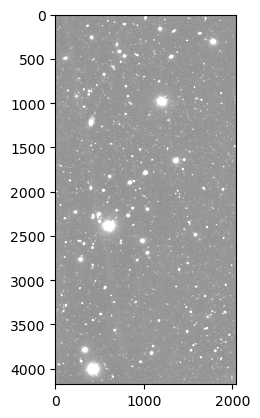

In [29]:
plt.imshow(calexp.image.array, cmap='gray', norm=calexpNorm)

In [30]:
import IPython
from IPython.display import IFrame
afwDisplay.setDefaultBackend('firefly')
display1 = afwDisplay.Display(frame=1, name='DM-37622-1')
display2 = afwDisplay.Display(frame=2, name='DM-37622-2')
display3 = afwDisplay.Display(frame=3, name='DM-37622-3')
display4 = afwDisplay.Display(frame=4, name='DM-37622-4')

#display1 = afwDisplay.Display('DM-37622')
IFrame(display1._url, 1000, 1200)

In [31]:
badFlagList1 = ['base_PixelFlags_flag_bad',
               'base_PixelFlags_flag_suspect',
               'base_PixelFlags_flag_saturatedCenter',
               'base_PixelFlags_flag_interpolated',
               'base_PixelFlags_flag_interpolatedCenter',
               'base_PixelFlags_flag_edge',
               ]
badFlagList2 = badFlagList1 + ['slot_Shape_flag']

In [32]:
bitmask1 = defaultQuery._unpacker.makeFlagBitMask(badFlagList1, columnName='flags')
bitmask2 = defaultQuery._unpacker.makeFlagBitMask(badFlagList2, columnName='flags')
print(bin(bitmask1))
print(bin(bitmask2))

0b1111001100
0b100000000000001111001100


In [33]:
display1.mtv(calexp)
display2.mtv(calexp)
display3.mtv(calexp)
display4.mtv(calexp)

In [34]:
bitmask = bitmask2

In [35]:
MATCH_RADIUS_ARCSEC = 0.001
fluxCut = -999999
print(bin(bitmask))
# Get the DiaSources good both in SdssShape and HsmShape
#firstloc = dfmp.loc[(dfmp['truth_xmatch_dist_arcsec'] <= MATCH_RADIUS_ARCSEC) & \
#                       (dfmp['psFlux_x'] >= fluxCut)]
firstloc = dfmp.loc[(dfmp['visit_x'] == myvisit) & (dfmp['detector_x'] == mydet) & \
                       (dfmp['truth_xmatch_dist_arcsec'] <= MATCH_RADIUS_ARCSEC) & \
                       (dfmp['psFlux_x'] >= fluxCut) & \
                   ((dfmp['flags_x'] & bitmask1) == 0)]
bothGood = firstloc.loc[((dfmp['flags_x'] & bitmask) == 0) & \
                   ((dfmp['flags_y'] & bitmask) == 0)]
# good in SdssShape, bad in HsmShape
sdssGood = firstloc.loc[((dfmp['flags_x'] & bitmask) == 0) & \
                   ((dfmp['flags_y'] & bitmask) != 0)]
# bad in SdssShape; good in HsmShape
hsmGood = firstloc.loc[((dfmp['flags_x'] & bitmask) != 0) & \
                   ((dfmp['flags_y'] & bitmask) == 0)]
# bad in both
bothBad = firstloc.loc[((dfmp['flags_x'] & bitmask) != 0) & \
                   ((dfmp['flags_y'] & bitmask) != 0)]
print('crosscheck: sum of categories = {}, total sources = {}.'.format(
    len(bothGood)+len(sdssGood)+len(hsmGood)+len(bothBad), len(firstloc)))

0b100000000000001111001100
crosscheck: sum of categories = 68, total sources = 68.


In [36]:
with display1.Buffering():
    for _,record in bothGood.iterrows():
        display1.dot('x', record['x_x'], record['y_x'], size=30, ctype='cyan')

In [37]:
with display2.Buffering():
    for _,record in sdssGood.iterrows():
        display2.dot('x', record['x_x'], record['y_x'], size=30, ctype='magenta')

In [38]:
with display3.Buffering():
    for _,record in hsmGood.iterrows():
        display3.dot('x', record['x_x'], record['y_x'], size=30, ctype='cyan')

In [39]:
with display4.Buffering():
    for _,record in bothBad.iterrows():
        display4.dot('x', record['x_x'], record['y_x'], size=30, ctype='red')

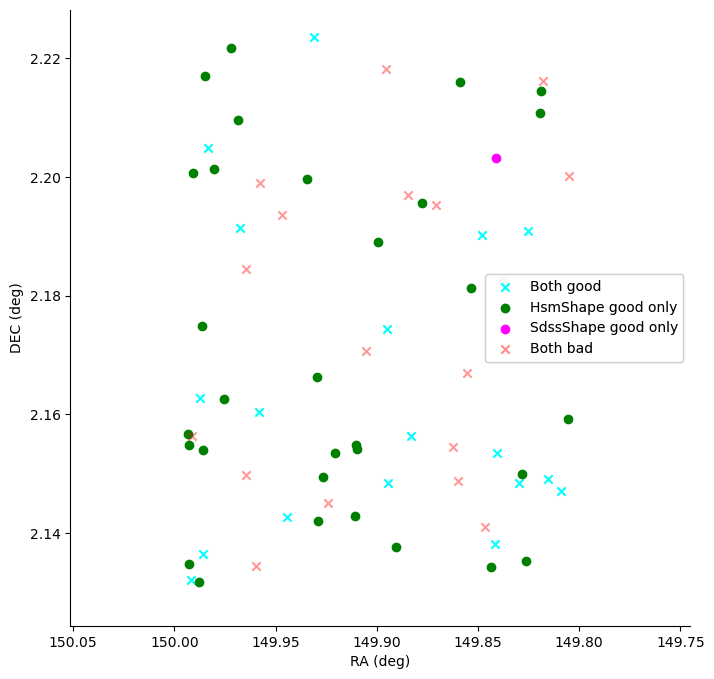

In [40]:
overlayfig = plt.figure(figsize=[8.0, 8.0])
#histgspec = histfig.add_gridspec(3, 2)
#    autofig = plt.figure(figsize=[14.0, 14.0])
    #collection_list = [default_best, middle_convolvesci, preconvolve_best, preconvolve_middle]
iplt = 0
leglabels = ['Both good', 'HsmShape good only', 'SdssShape good only',
             'Both bad'] 
ax = overlayfig.add_subplot()
xlim = (max(bothBad['ra_x'])+0.06, min(bothBad['ra_x'])-0.06)
ylim = (min(bothBad['decl_x'])-0.01, max(bothBad['decl_x'])+0.01)

plt.setp(ax, xlim=xlim, ylim=ylim)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.scatter(bothGood['ra_x'], bothGood['decl_x'], c='cyan', marker='x')
ax.set_xlabel('RA (deg)')
ax.set_ylabel('DEC (deg)')

ax.scatter(hsmGood['ra_x'], hsmGood['decl_x'], marker='o',color='green')
ax.scatter(sdssGood['ra_x'], sdssGood['decl_x'],marker='o',color='magenta')
ax.scatter(bothBad['ra_x'], bothBad['decl_x'], color='r', marker='x', alpha=0.4)
mylegend = ax.legend(labels=leglabels, loc='best')
ax.add_artist(mylegend)

In [41]:
mydefault = defaultsources.loc[(defaultsources['psFlux'] >= fluxCut) \
                                    & (defaultsources['visit'] == myvisit) \
                                    & (defaultsources['detector'] == mydet)]
mygooddefault = goodSlotShape.loc[(goodSlotShape['psFlux'] >= fluxCut) \
                                    & (goodSlotShape['visit'] == myvisit) \
                                    & (goodSlotShape['detector'] == mydet)]

/opt/lsst/software/stack/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-6.0.0/lib/python3.10/site-packages/astropy/units/function/logarithmic.py:65: RuntimeWarning: invalid value encountered in log10
  return dex.to(self._function_unit, np.log10(x))


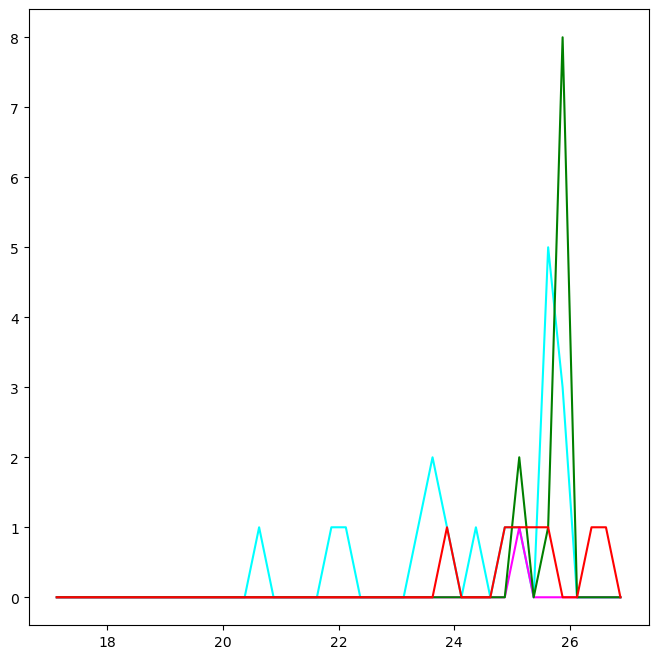

In [42]:
magfig = plt.figure(figsize=[8.0, 8.0])
#histgspec = histfig.add_gridspec(3, 2)
#    autofig = plt.figure(figsize=[14.0, 14.0])
    #collection_list = [default_best, middle_convolvesci, preconvolve_best, preconvolve_middle]
iplt = 0
leglabels = ['Both good', 'HsmShape good only', 'SdssShape good only',
             'Both bad'] 
ax = magfig.add_subplot()
nbins=40
minmag = 17
maxmag = 27
bothGoodHist, bin_edges = np.histogram((bothGood['psFlux_x'].to_numpy()*u.nJy).to_value(u.ABmag),
                  bins=nbins,  range=(minmag, maxmag))
sdssGoodHist, bin_edges = np.histogram((sdssGood['psFlux_x'].to_numpy()*u.nJy).to_value(u.ABmag),
                  bins=nbins,  range=(minmag, maxmag))
hsmGoodHist, bin_edges = np.histogram((hsmGood['psFlux_x'].to_numpy()*u.nJy).to_value(u.ABmag),
                  bins=nbins,  range=(minmag, maxmag))
bothBadHist, bin_edges = np.histogram((bothBad['psFlux_x'].to_numpy()*u.nJy).to_value(u.ABmag),
                  bins=nbins,  range=(minmag, maxmag))

bin_centers = [(bin_edges[i] + bin_edges[i + 1])/2 for i in range(len(bin_edges) - 1)]
plt.plot(bin_centers, bothGoodHist, label=myvisit, color='cyan')
plt.plot(bin_centers, sdssGoodHist, label=myvisit, color='magenta')
plt.plot(bin_centers, hsmGoodHist, label=myvisit, color='green')
plt.plot(bin_centers, bothBadHist, label=myvisit, color='red')

plt.show()

In [43]:
gc.collect()

70

In [44]:
myw04 = w04sources.loc[(w04sources['psFlux'] >= fluxCut) \
                                    & (w04sources['visit'] == myvisit) \
                                    & (w04sources['detector'] == mydet)]
mygoodw04 = goodSlotShapew04.loc[(goodSlotShapew04['psFlux'] >= fluxCut) \
                                    & (goodSlotShapew04['visit'] == myvisit) \
                                    & (goodSlotShapew04['detector'] == mydet)]

Groups we want:

* good in both new and old (positive flux only)
* good in old, bad in new
* bad in old, good in new (including negative flux)
* bad in both (all flux)

Scatter plots in different color, flux/mag plots, overlay of image with firefly (4 panels), 

In [45]:
mycomp = {}
mygoodcomp = {}
del(mycomp)
mycomp = pd.merge(myw04, mydefault, left_on='diaSourceId', 
                  right_on='diaSourceId', how='outer')
mygoodcomp = pd.merge(mygoodw04, mygooddefault, left_on='diaSourceId', 
                  right_on='diaSourceId', how='outer')

In [46]:
#for visit, detector in visit_det:
#    if visit == 11692 and detector == 50: continue
#    defSrcs = defaultsources.loc[(defaultsources['visit'] == visit) \
#                                    & (defaultsources['detector'] == detector)]
#    zcDefault.write_images(defSrcs,
#                           butler=dafButler.Butler(repo,
#                                                   collections=default_convolveTemplate.collection),
#                                                  njobs=2)
#    gc.collect()

In [47]:
#for visit, detector in visit_det:
#    if visit == 11692 and detector == 50: continue

#    w04Srcs = w04sources.loc[(w04sources['visit'] == visit) \
#                                    & (w04sources['detector'] == detector)]
##    print(visit, detector, len(defSrcs), len(w04Srcs))
##    print('----------')
#    zc04.write_images(w04Srcs,
#                   butler=dafButler.Butler(repo,
#                                           collections=w04_convolveTemplate.collection),
#                     njobs=2)
#    gc.collect()

    

In [46]:
from IPython.display import Image
def plotSources(data, visit=None, detector=None, path=None, chunk_size=10000, stride=1,
               offset=0, limit=-1):
    if path is None:
        raise ValueError('Image path is required.')
    nplotted = 0
    idx = 0
    if visit is not None and detector is not None:
        firstLoc = data.loc[(data['visit_x'] == visit) & (data['detector_x'] == detector)]
    elif detector is not None:
        firstLoc = data.loc[(data['visit_x'] == visit)]
    elif visit is not None:
        firstLoc = data.loc[(data['detector_x'] == detector)]
    else:
        firstLoc = data
    if not isinstance(stride, int) or stride < 1:
        raise ValueError('stride must be a positive integer.')
    for _, irow in firstLoc.iterrows():
        if limit > -1 and nplotted >= limit: return
        if idx < offset:
            idx += 1
            continue
        if (idx+offset)%stride == 0:
            print(irow['diaSourceId'])
            chunked = (irow['diaSourceId'] // chunk_size)* chunk_size
            fpath = os.path.join(path, f"images/{chunked}/{irow['diaSourceId']}.png")
            if not os.path.exists(fpath):
                print("ERROR: {}: no such file".format(fpath))
                idx += 1
                continue
            display(Image(filename=fpath))
            nplotted += 1
        idx += 1

12601541420646882


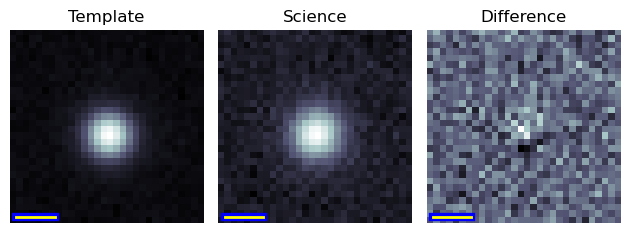

In [47]:
# Sources that are good in SdssShape but bad in HsmShape
plotSources(sdssGood, myvisit, mydet, zc04._output_path)

12601541420646846


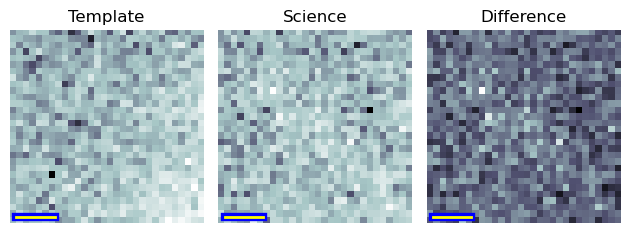

12601541420646857


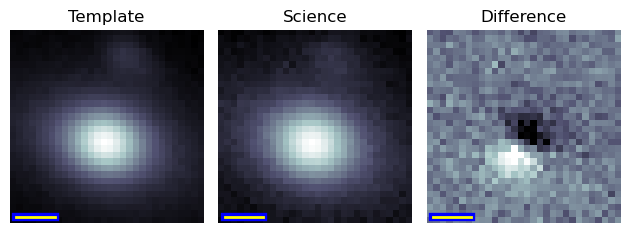

12601541420646864


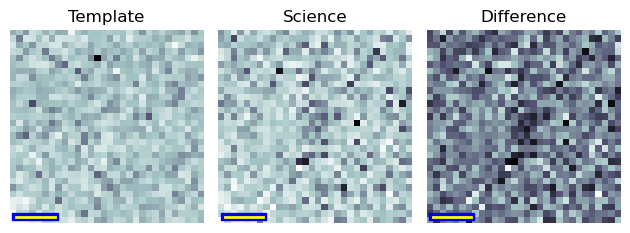

In [48]:
# Sources that are good in HsmShape but bad in SdssShape
plotSources(hsmGood, myvisit, mydet, zcDefault._output_path, offset=2,
            limit=3)

12601541420646816


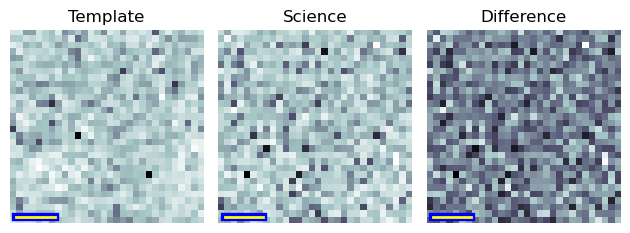

12601541420646957


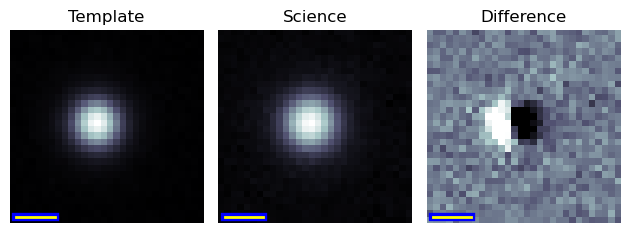

12601541420647068


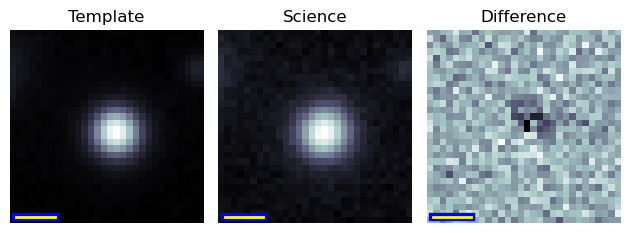

12601541420647116


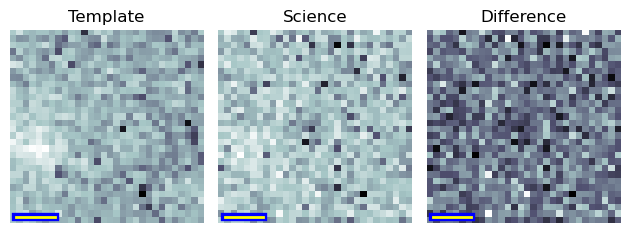

In [49]:
plotSources(hsmGood, myvisit, mydet, zcDefault._output_path, stride=10,
            offset=0, limit=10)

12601541420646816


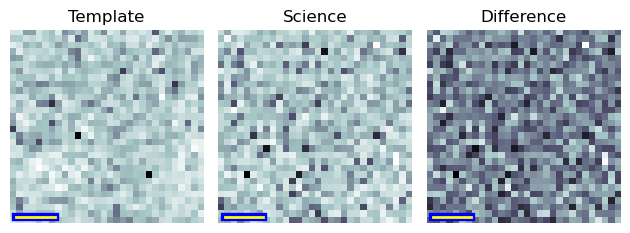

12601541420646957


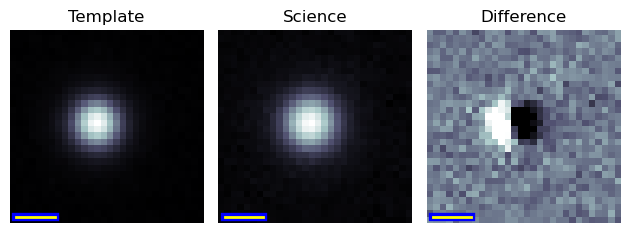

12601541420647068


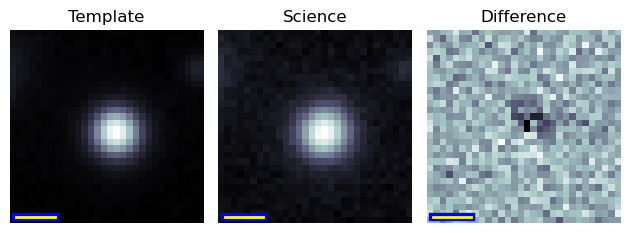

12601541420647116


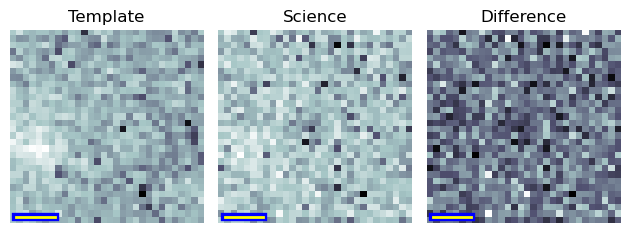

In [50]:
plotSources(hsmGood, path=zcDefault._output_path, stride=10,
            offset=0, limit=10)

12601541420646817


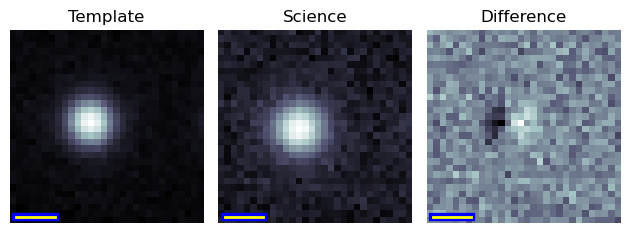

12601541420646911


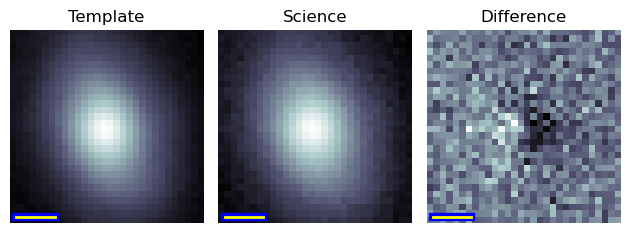

12601541420646961


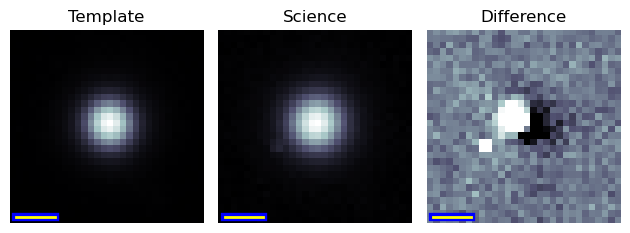

12601541420647057


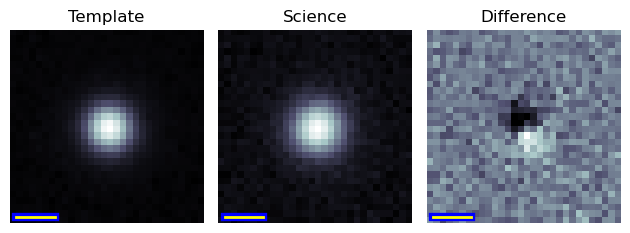

12601541420647110


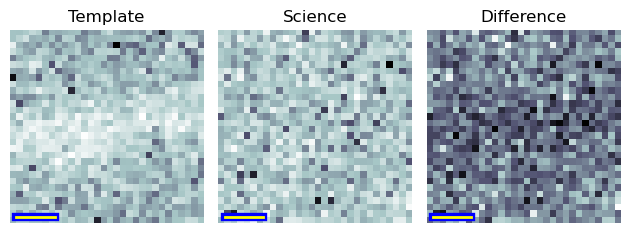

In [51]:
plotSources(bothBad, myvisit, mydet, zcDefault._output_path,
            offset=0, stride=4, limit=5)

In [52]:
hsmGoodFull = dfmp.loc[(dfmp['psFlux_x']>=fluxCut) \
                                 & ((dfmp['flags_y'] & bitmask2) == 0) \
                                 & ((dfmp['flags_x'] & bitmask2) != 0)]

In [53]:
baseGood = dfmp.loc[(dfmp['psFlux_x']>=fluxCut) \
                                 & ((dfmp['flags_x'] & bitmask1) == 0)]
print('Total good sources passing canonical flags: {}'.format(len(baseGood)))
hsmGoodFull = baseGood.loc[(baseGood['flags_y'] & bitmask2) == 0]
print('Total HsmShape sources passing canonical flags + slot shape: {}'.format(len(hsmGoodFull)))
print("Pos Flux: {}".format(len(hsmGoodFull.loc[hsmGoodFull['psFlux_y']>=0])))
print("Neg Flux: {}".format(len(hsmGoodFull.loc[hsmGoodFull['psFlux_y']<0])))
srcsGained = dfmp.loc[(dfmp['psFlux_x']>=fluxCut) \
                                 & ((dfmp['flags_x'] & bitmask1) == 0) \
                                 & ((dfmp['flags_x'] & bitmask2) != 0) \
                     & ((dfmp['flags_y'] & bitmask2) == 0) ]
print('We will gain {} sources of {} otherwise good sources in total when switching to hsmShape.'.format(len(srcsGained),
                                                                              len(baseGood)))
print('Of those, {} ({}) are positive (negative) flux.'.format(len(srcsGained.loc[srcsGained['psFlux_x']>=0]),
                                                                   len(srcsGained.loc[srcsGained['psFlux_x']<0])))
                                                                   
srcsLost = dfmp.loc[(dfmp['psFlux_x']>=fluxCut) \
                                 & ((dfmp['flags_x'] & bitmask1) == 0) \
                                 & ((dfmp['flags_x'] & bitmask2) == 0) \
                     & ((dfmp['flags_y'] & bitmask2) != 0) ]
print('We will lose {} sources of {} otherwise good sources in total when switching to hsmShape.'.format(len(srcsLost),
                                                                              len(baseGood)))

# both pass the slot shape flag
bothGood = baseGood.loc[(baseGood['psFlux_x']>=fluxCut) \
                                 & ((baseGood['flags_x'] & bitmask2) == 0) \
                   & ((baseGood['flags_y'] & bitmask2) == 0)]

# neither passes slot shape flag
bothBad = baseGood.loc[(baseGood['psFlux_x']>=fluxCut) \
                                 & ((baseGood['flags_x'] & bitmask2) != 0) \
                   & ((baseGood['flags_y'] & bitmask2) != 0)]
bothBadNeg = bothBad.loc[bothBad['psFlux_x']<0]

print('Both Good: {}'.format(len(bothGood)))
print('Both Bad: {}, {}({}) pos (neg) flux'.format(len(bothBad), len(bothBad)-len(bothBadNeg),len(bothBadNeg)))

Total good sources passing canonical flags: 13258
Total HsmShape sources passing canonical flags + slot shape: 8451
Pos Flux: 3534
Neg Flux: 4917
We will gain 5999 sources of 13258 otherwise good sources in total when switching to hsmShape.
Of those, 1082 (4917) are positive (negative) flux.
We will lose 735 sources of 13258 otherwise good sources in total when switching to hsmShape.
Both Good: 2452
Both Bad: 4072, 1897(2175) pos (neg) flux


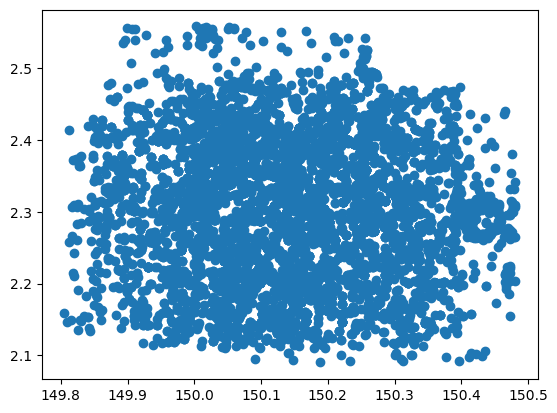

In [54]:
plt.scatter(hsmGoodFull['ra_y'], hsmGoodFull['decl_y'])

In [55]:
def plotHists(quantity, data=None, bins=None, xlabel=None, ylabel=None,
             title=None, colors=None, logy=False):
    """ Plot histograms of a particular quantity for each of 
    a list of Pandas dataframes.
    
    Parameters
    ----------
    
    quantity: `str`
       Column name to be plotted; must exist in all dataframes
    data: `list`
        List of pandas dataframes
    bins: `int` or `list`, optional
        Binning to be used for histograms
    xlabel: `str`, optional
    
    yabel: `str`, optional
    
    title: `str` or `list` of `str`, optional
    colors: `list`, optional
    logy: `bool`, default = False
        set the y axis to log scale
    """
    if data is None:
        raise ValueError('Missing list of input dataset(s).')
    if bins is None:
        raise ValueError('Must specify histogram binning.')
    if colors is None:
        colors = [ 'b', 'r', 'g', 'k', 'y', 'c']
 #   if mrkrs is None:
 #       mrkrs = [ 'o', 'v', 's', '*', '^', 'p' ]
    iplt = 0
    histfig =  plt.figure(figsize=[7.0, 7.0])
    overlayfig =  plt.figure(figsize=[10, 10])
    histgspec = histfig.add_gridspec(2, 2)
    for dset in data:
        histax = histfig.add_subplot(histgspec[int(iplt/2),iplt%2])
        dset.hist(column=quantity, bins=bins, grid=False, ax=histax,
                 color=colors[iplt],log=logy)
        if xlabel is not None:
            histax.set_xlabel(xlabel)
        else:
            histax.set_xlabel(quantity)
        if ylabel is not None:
            histax.set_ylabel(ylabel)
        else:
            histax.set_ylabel('Count')
        if title is not None:
            if isinstance(title, list) :
                histax.set_title(title[iplt])
            else:
                histax.set_title(title)
        iplt += 1
    plt.show()

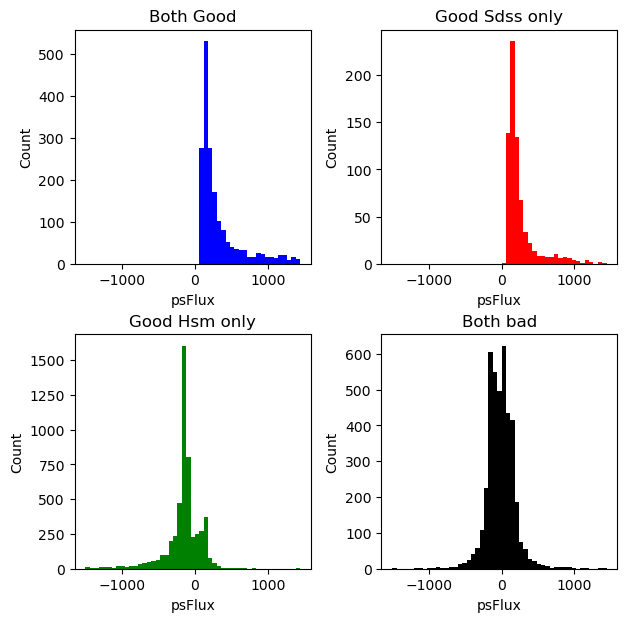

<Figure size 1000x1000 with 0 Axes>

In [56]:
plotHists('psFlux_x', data=[bothGood, srcsLost, srcsGained, bothBad],
          bins=range(-1500,1500, 60), xlabel='psFlux', title=['Both Good', 'Good Sdss only',
                                             'Good Hsm only', 'Both bad'])

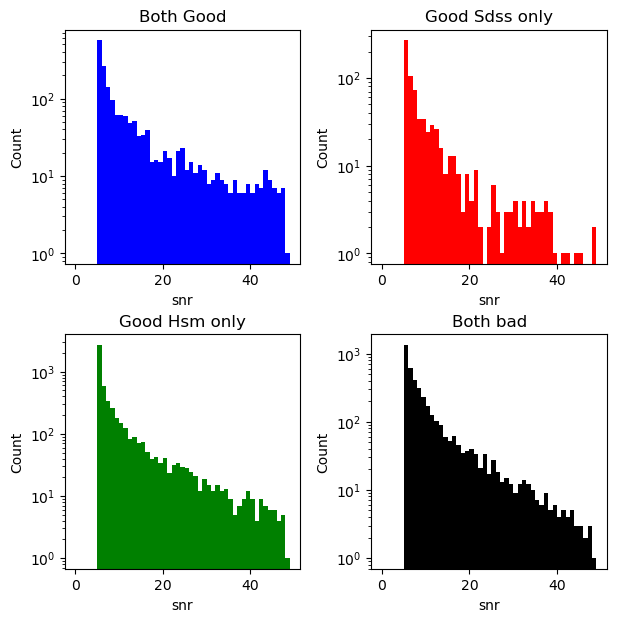

<Figure size 1000x1000 with 0 Axes>

In [60]:
plotHists('snr_y', data=[bothGood, srcsLost, srcsGained, bothBad],
          bins=range(0,50), xlabel='snr', title=['Both Good', 'Good Sdss only',
                                             'Good Hsm only', 'Both bad'],
         logy=True)

In [57]:
plt.close()

In [58]:
gc.collect()

22769

517219289137764


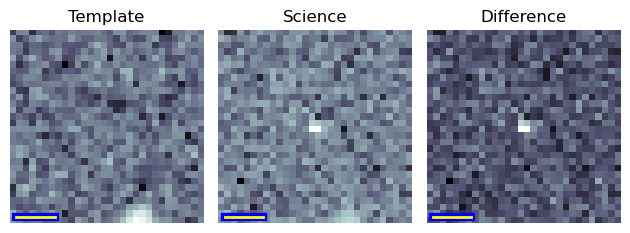

517238616491272


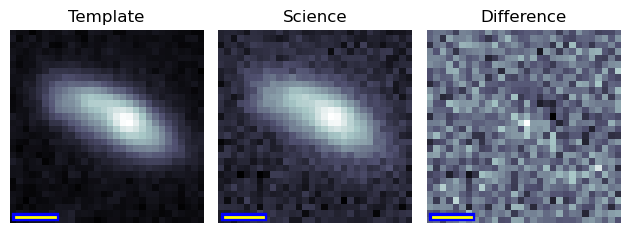

518956603409152


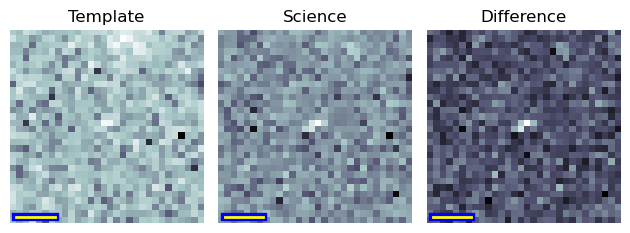

521533583786980


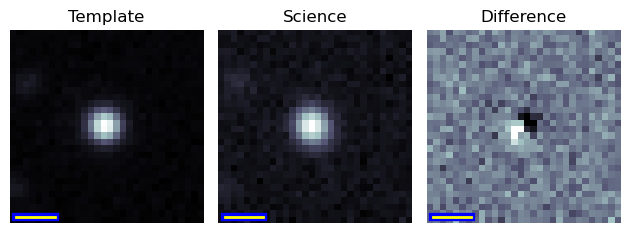

522375397377262


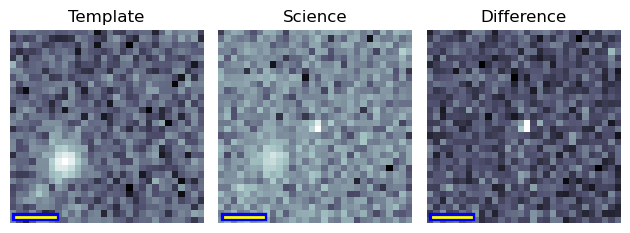

523232243352417


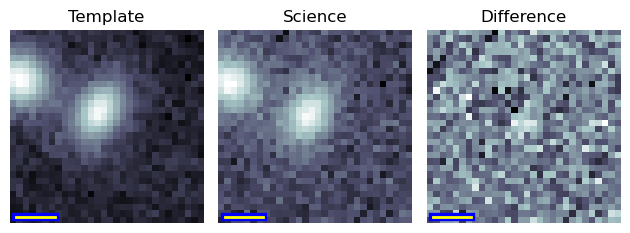

In [59]:
plotSources(srcsLost, path=zcDefault._output_path,
            offset=0, stride=50, limit=6)

517221436622039


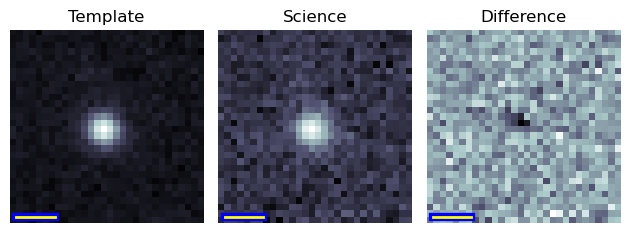

517221436622721


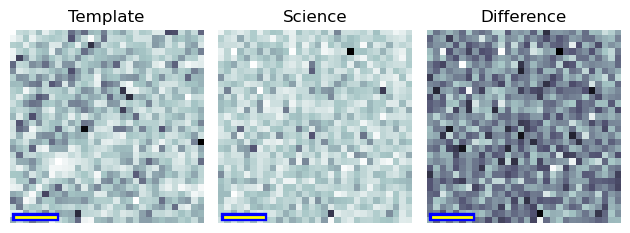

517236469007161


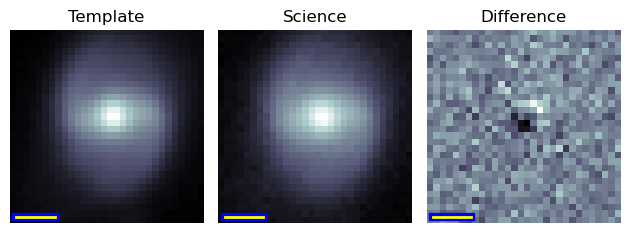

517238616490869


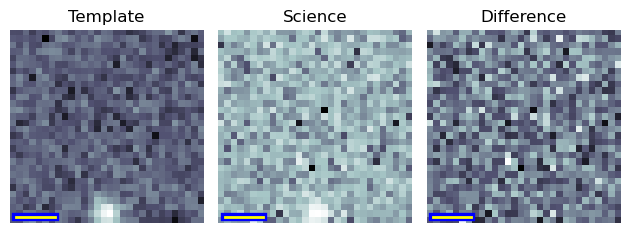

517253648876334


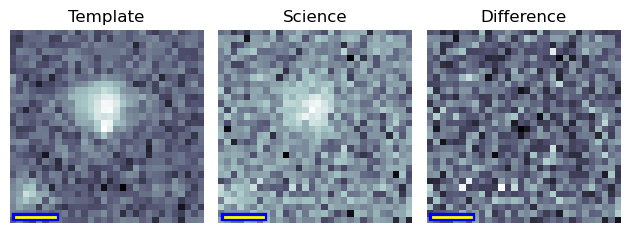

517253648876723


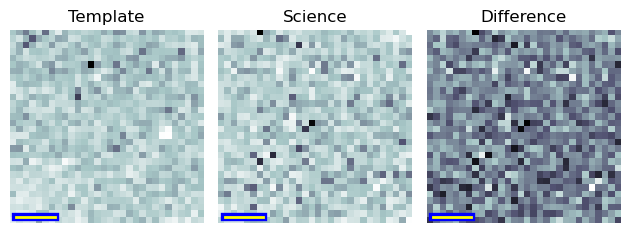

In [60]:
plotSources(srcsGained, path=zcDefault._output_path,
            offset=2, stride=50, limit=6)

517221436622696


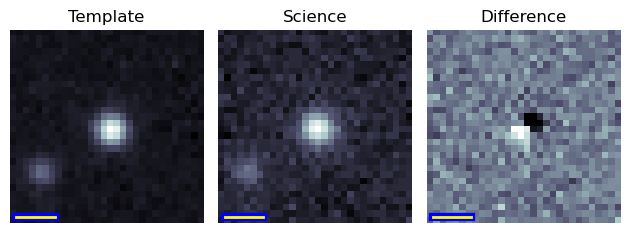

517238616491165


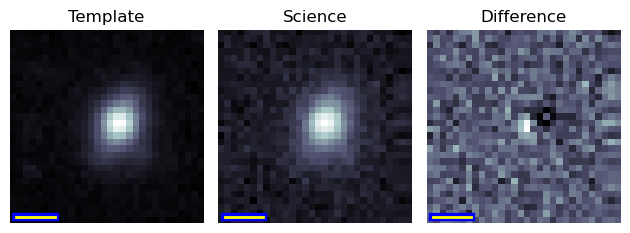

517255796360601


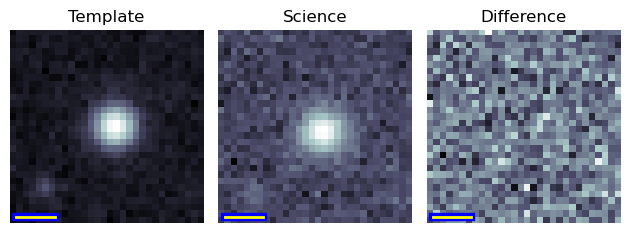

518954455925504


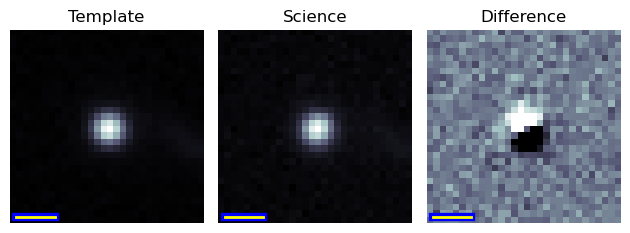

518971635795058


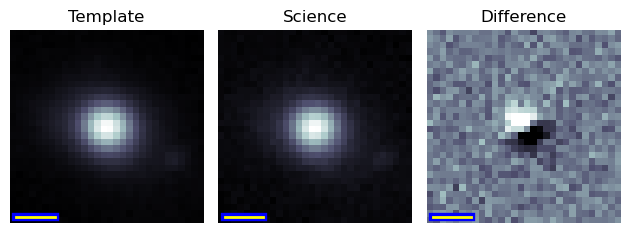

521516403918023


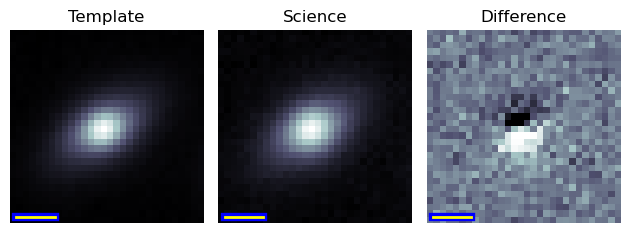

In [61]:
plotSources(bothBad, path=zcDefault._output_path,
            offset=1, stride=100, limit=6)

In [62]:
gc.collect()

0